# Expe 1, injecting noise in participant A2

In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1'
trial_info_file = '/data/A2/converted/trialinfo_matrix_A2_cleanedtrials.mat'
data_file = '/data/A2/Experimental/data.mat'
epoch_file = '/epochs_from_matrix/epochs_2.fif'

# Posterior electrodes
relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz'] 
# Best electrodes in frequency tagging condition
freqtag_electrodes = ['Iz', 'PO3', 'POz', 'P3', 'P7', 'P5']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'ignore_column':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from noise_tagging_funs import normalize_per_trial, generate_noise_periods, cross_cor_nois, compute_other_trial_crosscorr

In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']

# Get target binary (i.e if a shift happened)
f = sio.loadmat(f'{data_path}{data_file}')
target_binary =f['data']['targets_binary'][0][0]
# Remove practice trials
target_binary = target_binary[1:,:]
# Collapse to trial indexes
original_shape = target_binary.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
target_binary = np.reshape(target_binary, new_shape)
target_binary = pd.DataFrame({'trial_number':np.arange(target_binary.shape[0]), 'target_binary':target_binary})

# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())
pd_info['trial_number']= pd_info['trial_number'].astype(int) - 1
pd_info = pd.merge(pd_info, target_binary, on = 'trial_number')

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info


Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif ...


/tmp/ipykernel_87242/448556551.py:22: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
467 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 16 columns


In [4]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

# Keep only trials without targets
epochs = epochs['target_binary == 0']

# Resample to the projectors sampling rate
epochs.resample(480)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,380
Events,1: 380
Time range,-1.000 – 2.298 s
Baseline,off


# Adding 5% of Noise

In [5]:
epochs_noistag = epochs['tagging_type==1'].copy()
# Access noise tags
f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

In [6]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

In [7]:
sfreq = 480
noise_stims_tr_fitlered = mne.filter.filter_data(noise_stims_tr, sfreq, None, 100)
tmin = epochs_noistag.tmin
tmax = epochs_noistag.tmax
#Up to when should the tag be present
tmax_noise = 1
# Inject to each EEG epoch its matching cued tag
buffer_arr = epochs_noistag.get_data()
# z-score EEG by electrode and trial
buffer_arr = (buffer_arr - np.mean(buffer_arr, axis=2, keepdims=True))/np.std(buffer_arr, axis=2, keepdims=True)
# Reverse the EEG to ensure no real crosscorrelation
buffer_arr = buffer_arr[:,:,::-1]

# After which sample from cue onset should the noise be in the data
for idx, trial in enumerate(epochs_noistag.metadata['trial_number']):
    # Delay is the delay between stimulation and translation in brain, here 100ms
    delay = int(.1*sfreq)
    # Offset is the moment where the noise is injected
    offset = int(np.random.normal(.1, .020)*sfreq)
    # Retrieve which tag was cued
    cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])
    # Inject the tag displayed from cue onset to 800 ms after
    injected_tag = noise_stims_tr_fitlered[trial, cued_side, \
        :int(tmax_noise*sfreq)+1]
    # z-score tag
    injected_tag = (injected_tag - np.mean(injected_tag))/np.std(injected_tag)
    # Offset the moment of crosscorrelation but preserve phase
    injected_tag[:offset] = 0
    # Relative magnitude of the tag in the EEG
    injected_tag *= 0.05265#0.111111#0.01010101
    # Add the tag from cue onset + time delay (offset)
    buffer_arr[idx,:,int(np.abs(epochs_noistag.tmin)*sfreq)+delay:int(np.abs(epochs_noistag.tmin)*sfreq+delay)+len(injected_tag)] += injected_tag
epochs_noistag._data = buffer_arr


Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 65 samples (0.135 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
/tmp/ipykernel_87242/3360792912.py:8: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  buffer_arr = epochs_noistag.get_data()
/tmp/ipykernel_87242/3360792912.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])


In [8]:
# bandpass (60-80Hz) EEG data 
epochs_noistag.filter(l_freq=60, h_freq = 80, verbose=True)

Setting up band-pass filter from 60 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 107 samples (0.223 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s


Number of events,192
Events,1: 192
Time range,-1.000 – 2.298 s
Baseline,off


## 1. Cross-correlation of the cued and uncued tags (tag duration from 0 to 1s)

The EEG from -1 to 2s is correlated with the tags from 0 to 1s (positive time lag up to 1000ms). 
Only trials without targets are included. 
The EEG is correlated with each tag.
The electrodes used are the best from the frequency tagging condition.

Text(0, 0.5, 'Cor EEG/tag')

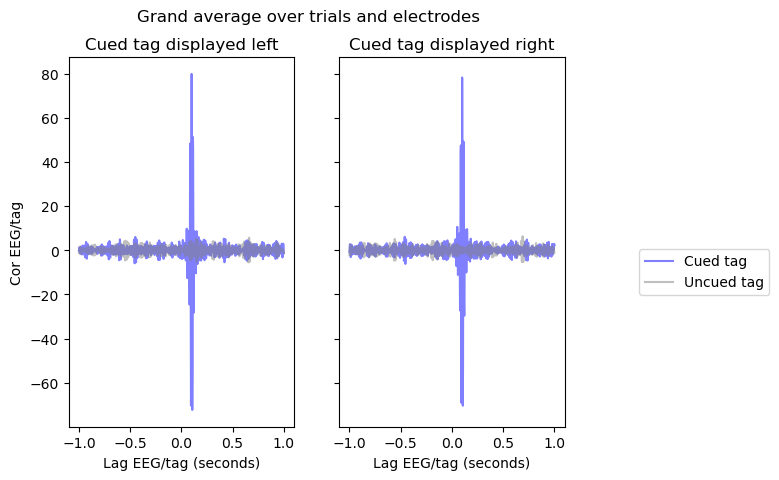

In [9]:
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2
tmin_noise, tmax_noise = 0, 1

cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag['target_binary == 0'], noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag['target_binary == 0'], noise_stims_tr, 'left', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


# Plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(times,cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(times,cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)
ax[1].plot(times,cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='Cued tag', alpha=.5)
ax[1].plot(times,cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='Uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');
plt.suptitle('Grand average over trials and electrodes');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')

## 2. Trial averaged analysis

### 2.1 pre vs post-display

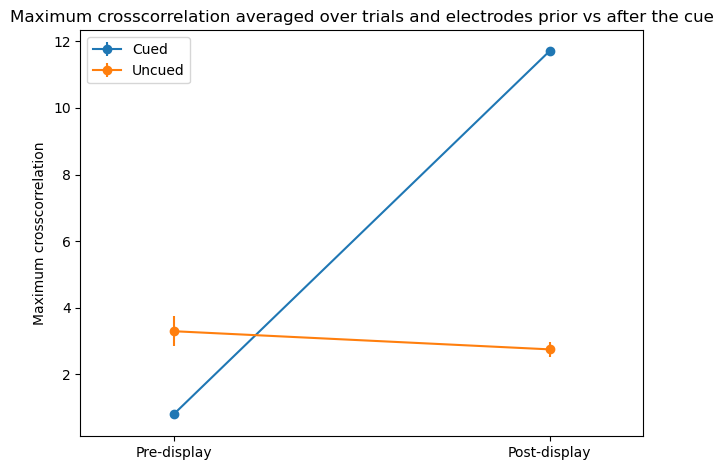

In [10]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


max_precue_cued = np.abs(normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,:int(times.max()*sfreq)]).max(axis=-1)
max_postcue_cued = np.abs(normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,-int(times.max()*sfreq):]).max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
max_precue_uncued = np.abs(normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,:int(times.max()*sfreq)]).max(axis=-1)
max_postcue_uncued = np.abs(normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,-int(times.max()*sfreq):]).max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                yerr=[np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
                        
plt.xticks([0,1],['Pre-display', 'Post-display'])
plt.title('Maximum crosscorrelation averaged over trials and electrodes prior vs after the cue')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

### 2.2 Comparing max cross-correlation on displayed trial vs others

In [11]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 2

# First for left cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes=freqtag_electrodes, \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matL[0, trial_idx, :, :, :] = cor_with_cued_for_cuedL[:, :, :]
    trial_crosscorr_matL[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedL[:, :, :]

# For right cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 1'].selection]
trial_crosscorr_matR = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes=freqtag_electrodes,  \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matR[0, trial_idx, :, :, :] = cor_with_cued_for_cuedR[:, :, :]
    trial_crosscorr_matR[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedR[:, :, :]

In [12]:
same_cued, same_uncued = [], []
other_cued, other_uncued = [], []

num_trials = trial_crosscorr_matL[0].shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same_cued.append(trial_crosscorr_matL[0][trial, trial])
    same_uncued.append(trial_crosscorr_matL[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matL[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matL[1][trial, sampled_index])
    
num_trials = trial_crosscorr_matR[0].shape[0]
for trial in range(num_trials):
    same_cued.append(trial_crosscorr_matR[0][trial, trial])
    same_uncued.append(trial_crosscorr_matR[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matR[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matR[1][trial, sampled_index])

plt.errorbar(x=[0,1], y=[np.abs(normalize_per_trial(np.array(same_cued).mean(axis=(0))).max(axis=-1).mean()), np.abs(normalize_per_trial(np.array(other_cued).mean(axis=(0))).max(axis=-1).mean()]),
                yerr=[np.abs(normalize_per_trial(np.array(same_cued).mean(axis=(0))).max(axis=-1).std()), np.abs(normalize_per_trial(np.array(other_cued).mean(axis=(0))).max(axis=-1).std())], fmt='o-', label='Cued')
plt.errorbar(x=[0,1], y=[np.abs(normalize_per_trial(np.array(same_uncued).mean(axis=(0))).max(axis=-1).mean()), np.abs(normalize_per_trial(np.array(other_uncued).mean(axis=(0))).max(axis=-1).mean()]),
                yerr=[np.abs(normalize_per_trial(np.array(same_uncued).mean(axis=(0))).max(axis=-1).std()), np.abs(normalize_per_trial(np.array(other_uncued).mean(axis=(0))).max(axis=-1).std())], fmt='o-', label='Uncued')
plt.xticks([0,1],['Same', 'Other'])
plt.title('Comparison of the maximum of the crosscorrelation on same vs other trials')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (1059117647.py, line 29)

## 3. Trial-by-trial analysis

### 3.1 Comparing by trial cross-correlation on displayed trial vs others

In [ ]:
fig, ax = plt.subplots(1,2)
# Extract the max for each trial, average cor over best noise tagging electrodes
trialL = np.mean(np.abs(trial_crosscorr_matL[0][:, :, :,:]).max(axis=-1), axis=2)
trialR = np.mean(np.abs(trial_crosscorr_matR[0][:, :, :,:]).max(axis=-1), axis=2)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_cued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_cued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])
print(f'T-test for same vs others on cued:{scipy.stats.ttest_ind(same_trial_cued,other_trial_cued,equal_var=False)}')

sns.kdeplot(same_trial_cued, color='blue', ax=ax[0])
sns.kdeplot(other_trial_cued, color='red', ax=ax[0])
ax[0].plot([0],[0], label='Same trials', color='blue')
ax[0].plot([0],[0], label='Other trials', color='red')
ax[0].set_xlabel('Maximum crosscorrelation')
ax[0].set_title('Cued tag')
plt.legend()

# Extract the max for each trial, average cor over best noise tagging electrodes
trialL = np.mean(np.abs(trial_crosscorr_matL[1][:, :, :,:]).max(axis=-1), axis=2)
trialR = np.mean(np.abs(trial_crosscorr_matR[1][:, :, :,:]).max(axis=-1), axis=2)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_uncued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_uncued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])
print(f'T-test for same vs others on cued:{scipy.stats.ttest_ind(same_trial_uncued,other_trial_uncued,equal_var=False)}')

sns.kdeplot(same_trial_uncued, color='blue', ax=ax[1])
sns.kdeplot(other_trial_uncued, color='red', ax=ax[1])
ax[1].plot([0],[0], label='Same trials', color='blue')
ax[1].plot([0],[0], label='Other trials', color='red')
ax[1].set_title('Uncued tag')
ax[1].set_xlabel('Maximum crosscorrelation')
plt.suptitle('Maximum crosscorrelation between EEG and cued and uncued tag for the same vs other trials')
plt.legend()
plt.tight_layout()

### 3.2 testing max cross-correlation by-trial in different time windows of the noise

In [ ]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax

# Define lag
lag = .1

# Define period of noise to analyze
start = 0
duration = .4
step = .4
end = tmax_eeg-lag

# Create a list of tag segments
noise_periods = generate_noise_periods(start, end, duration, step)

# Matrix to store results
max_values_per_bin = np.zeros((len(noise_periods)+1, len(epochs_noistag)))

# For each of the tag segments
for j, period in enumerate(noise_periods):
    j += 1 #First period is baseline below
    tmin_noise, tmax_noise = period
    tmin_eeg_period, tmax_eeg_period = period
    tmax_eeg_period += lag
    
    # Get the crosscorrelation sliding over the all EEG epoch
    # With the average of the two tags when the cued side was right
    cor_with_avg_for_avgR, _, idx_avgR, times = \
        cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
        display_side_cued_tag = 'right',  electrodes=freqtag_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)

    # get other trial crosscorrelation
    other_trialL = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'left', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
    # take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
    other_trialL = np.abs(other_trialL).max(axis=-1).mean(axis=2).flatten()
    
    # With the average of the two tags when the avg side was left
    cor_with_avg_for_avgL, _, idx_avgL, times = \
        cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes=freqtag_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)
    # get other trial crosscorrelation for right
    other_trialR = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'right', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
    # take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
    other_trialR = np.abs(other_trialR).max(axis=-1).mean(axis=2).flatten()
    # Combine right and left avg side
    avg = np.concatenate([cor_with_avg_for_avgR,cor_with_avg_for_avgL])
    # Combine other trials for left and right avg side
    other = np.concatenate([other_trialR, other_trialL])

    # pick the max crosscorrelation, average over electrodes
    max_values_per_bin[j, :] = np.mean(np.abs(avg).max(axis=-1), axis=1) - other.mean()

# Baseline to compare with (intercept of the linear model) is the first part of the noise with the baseline EEG
tmin_noise, tmax_noise = 0, .4
tmin_eeg_period, tmax_eeg_period = -.5, 0

# Get the crosscorrelation sliding over the all EEG epoch
# With the average of the two tags when the cued side was right
cor_with_avg_for_avgR, _, idx_avgR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
    display_side_cued_tag = 'right',  electrodes=freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
    tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)

# get other trial crosscorrelation
other_trialL = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'left', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
# take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
other_trialL = np.abs(other_trialL).max(axis=-1).mean(axis=2).flatten()

# With the average of the two tags when the avg side was left
cor_with_avg_for_avgL, _, idx_avgL, times = \
    cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes=freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
    tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)
# get other trial crosscorrelation for right
other_trialR = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'right', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
# take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
other_trialR = np.abs(other_trialR).max(axis=-1).mean(axis=2).flatten()
# Combine right and left avg side
avg = np.concatenate([cor_with_avg_for_avgR,cor_with_avg_for_avgL])
# Combine other trials for left and right avg side
other = np.concatenate([other_trialR, other_trialL])

# pick the max crosscorrelation, average over electrodes
max_values_per_bin[j, :] = np.mean(np.abs(avg).max(axis=-1), axis=1) - other.mean()

#Add baseline to noise_periods
noise_periods.insert(0, (-0.4,0))


We fit a linear mixed effect model with the periods as predictor (baseline is intercept) and trial random effect for intercept and slopes

In [ ]:
df_trial = pd.DataFrame(max_values_per_bin.T)
df_trial.columns = [f'{x[0]:.1f}s' for i,x in enumerate(noise_periods)]
df_trial['trial'] = np.arange(len(df_trial))
df_trial_long = df_trial.melt(id_vars='trial', var_name='variable', value_name='value')

# Perform one-hot encoding on the noise periods
one_hot_encoded = pd.get_dummies(df_trial_long['variable'])

design_matrix = pd.concat([df_trial_long['value'],one_hot_encoded], axis=1)
trials =  df_trial_long['trial']

# Fit a LME
md = smf.mixedlm("value ~ Q('0.0s')+ Q('0.4s')+ Q('0.8s')+ Q('1.2s')+ Q('1.6s')", design_matrix, 
                 groups=trials, re_formula="~ 1 + Q('0.0s')+ Q('0.4s')+ Q('0.8s')+ Q('1.2s') + Q('1.6s')")
result = md.fit()
print(result.summary())

## 4. Coherence analysis

In [ ]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 2

# Perform a time-frequency analysis of the cross-correlation
freqs = np.arange(60, 80, step = 0.5)

same_cued, same_uncued = [], []
other_cued, other_uncued = [], []

num_trials = trial_crosscorr_matL[0].shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same_cued.append(trial_crosscorr_matL[0][trial, trial])
    same_uncued.append(trial_crosscorr_matL[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matL[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matL[1][trial, sampled_index])
    
num_trials = trial_crosscorr_matR[0].shape[0]
for trial in range(num_trials):
    same_cued.append(trial_crosscorr_matR[0][trial, trial])
    same_uncued.append(trial_crosscorr_matR[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matR[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matR[1][trial, sampled_index])
    
# Adapt the eeg info
epochs_noistag_cropped = epochs_noistag.copy().crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).pick(freqtag_electrodes).resample(sfreq)
# Do the time frequency analysis
itc_same = mne.time_frequency.tfr_array_morlet(same_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
itc_other = mne.time_frequency.tfr_array_morlet(other_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
# Store in MNE format
itc_same = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([itc_same]), epochs_noistag_cropped.times, freqs)
itc_other = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([itc_other]), epochs_noistag_cropped.times, freqs)


# Plot
fig, axes = plt.subplots(2, len(freqtag_electrodes), figsize=(15, 4), sharey = True) 
channels = epochs_noistag_cropped.info['ch_names']
for e, channel in enumerate(channels):
    itc_same.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[0,e],
        colorbar=True,
        show=False 
    )
    axes[0,e].set_title(channel) 
    itc_other.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[1,e],
        colorbar=True,
        show=False 
    )
plt.tight_layout()
plt.suptitle('Inter-trial coherence of same vs. other trials')
plt.show()

# Adding 2.3% of Noise

In [ ]:
epochs_noistag = epochs['tagging_type==1'].copy()
# Access noise tags
f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

In [ ]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

In [ ]:
sfreq = 480
# noise_stims_tr_fitlered = mne.filter.filter_data(noise_stims_tr, sfreq, None, 80)
tmin = epochs_noistag.tmin
tmax = epochs_noistag.tmax
#Up to when should the tag be present
tmax_noise = 1
# Inject to each EEG epoch its matching cued tag
buffer_arr = epochs_noistag.get_data()
# z-score EEG by electrode and trial
buffer_arr = (buffer_arr - np.mean(buffer_arr, axis=2, keepdims=True))/np.std(buffer_arr, axis=2, keepdims=True)
# Reverse the EEG to ensure no real crosscorrelation
buffer_arr = buffer_arr[:,:,::-1]

# After which sample from cue onset should the noise be in the data
for idx, trial in enumerate(epochs_noistag.metadata['trial_number']):
    # Delay is the delay between stimulation and translation in brain, here 100ms
    delay = int(.1*sfreq)
    # Offset is the moment where the noise is injected
    offset = int(np.random.normal(.1, .010)*sfreq)
    # Retrieve which tag was cued
    cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])
    # Inject the tag displayed from cue onset to 800 ms after
    injected_tag = noise_stims_tr_fitlered[trial, cued_side, \
        :int(tmax_noise*sfreq)+1]
    # z-score tag
    injected_tag = (injected_tag - np.mean(injected_tag))/np.std(injected_tag)
    # Offset the moment of crosscorrelation but preserve phase
    injected_tag[:offset] = 0
    # Relative magnitude of the tag in the EEG
    injected_tag *= 0.005
    # Add the tag from cue onset + time delay (offset)
    buffer_arr[idx,:,int(np.abs(epochs_noistag.tmin)*sfreq)+delay:int(np.abs(epochs_noistag.tmin)*sfreq+delay)+len(injected_tag)] += injected_tag
epochs_noistag._data = buffer_arr


In [ ]:
# bandpass (60-80Hz) EEG data 
epochs_noistag.filter(l_freq=60, h_freq = 80, verbose=True)

## 1. Cross-correlation of the cued and uncued tags (tag duration from 0 to 1s)

The EEG from -1 to 2s is correlated with the tags from 0 to 1s (positive time lag up to 1000ms). 
Only trials without targets are included. 
The EEG is correlated with each tag.
The electrodes used are the best from the frequency tagging condition.

In [ ]:
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2
tmin_noise, tmax_noise = 0, 1

cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag['target_binary == 0'], noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag['target_binary == 0'], noise_stims_tr, 'left', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


# Plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(times,cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(times,cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)
ax[1].plot(times,cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='Cued tag', alpha=.5)
ax[1].plot(times,cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='Uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');
plt.suptitle('Grand average over trials and electrodes');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')

## 2. Trial averaged analysis

### 2.1 pre vs post-display

In [ ]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


max_precue_cued = np.abs(normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,:int(times.max()*sfreq)]).max(axis=-1)
max_postcue_cued = np.abs(normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,-int(times.max()*sfreq):]).max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
max_precue_uncued = np.abs(normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,:int(times.max()*sfreq)]).max(axis=-1)
max_postcue_uncued = np.abs(normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,-int(times.max()*sfreq):]).max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                yerr=[np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
                        
plt.xticks([0,1],['Pre-display', 'Post-display'])
plt.title('Maximum crosscorrelation averaged over trials and electrodes prior vs after the cue')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

### 2.2 Comparing max cross-correlation on displayed trial vs others

In [ ]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 2

# First for left cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes=freqtag_electrodes, \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matL[0, trial_idx, :, :, :] = cor_with_cued_for_cuedL[:, :, :]
    trial_crosscorr_matL[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedL[:, :, :]

# For right cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 1'].selection]
trial_crosscorr_matR = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes=freqtag_electrodes,  \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matR[0, trial_idx, :, :, :] = cor_with_cued_for_cuedR[:, :, :]
    trial_crosscorr_matR[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedR[:, :, :]

In [ ]:
same_cued, same_uncued = [], []
other_cued, other_uncued = [], []

num_trials = trial_crosscorr_matL[0].shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same_cued.append(trial_crosscorr_matL[0][trial, trial])
    same_uncued.append(trial_crosscorr_matL[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matL[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matL[1][trial, sampled_index])
    
num_trials = trial_crosscorr_matR[0].shape[0]
for trial in range(num_trials):
    same_cued.append(trial_crosscorr_matR[0][trial, trial])
    same_uncued.append(trial_crosscorr_matR[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matR[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matR[1][trial, sampled_index])

plt.errorbar(x=[0,1], y=[np.abs(normalize_per_trial(np.array(same_cued).mean(axis=(0))).max(axis=-1).mean()), np.abs(normalize_per_trial(np.array(other_cued).mean(axis=(0))).max(axis=-1).mean()]),
                yerr=[np.abs(normalize_per_trial(np.array(same_cued).mean(axis=(0))).max(axis=-1).std()), np.abs(normalize_per_trial(np.array(other_cued).mean(axis=(0))).max(axis=-1).std())], fmt='o-', label='Cued')
plt.errorbar(x=[0,1], y=[np.abs(normalize_per_trial(np.array(same_uncued).mean(axis=(0))).max(axis=-1).mean()), np.abs(normalize_per_trial(np.array(other_uncued).mean(axis=(0))).max(axis=-1).mean()]),
                yerr=[np.abs(normalize_per_trial(np.array(same_uncued).mean(axis=(0))).max(axis=-1).std()), np.abs(normalize_per_trial(np.array(other_uncued).mean(axis=(0))).max(axis=-1).std())], fmt='o-', label='Uncued')
plt.xticks([0,1],['Same', 'Other'])
plt.title('Comparison of the maximum of the crosscorrelation on same vs other trials')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

## 3. Trial-by-trial analysis

### 3.1 Comparing by trial cross-correlation on displayed trial vs others

In [ ]:
fig, ax = plt.subplots(1,2)
# Extract the max for each trial, average cor over best noise tagging electrodes
trialL = np.mean(np.abs(trial_crosscorr_matL[0][:, :, :,:]).max(axis=-1), axis=2)
trialR = np.mean(np.abs(trial_crosscorr_matR[0][:, :, :,:]).max(axis=-1), axis=2)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_cued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_cued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])
print(f'T-test for same vs others on cued:{scipy.stats.ttest_ind(same_trial_cued,other_trial_cued,equal_var=False)}')

sns.kdeplot(same_trial_cued, color='blue', ax=ax[0])
sns.kdeplot(other_trial_cued, color='red', ax=ax[0])
ax[0].plot([0],[0], label='Same trials', color='blue')
ax[0].plot([0],[0], label='Other trials', color='red')
ax[0].set_xlabel('Maximum crosscorrelation')
ax[0].set_title('Cued tag')
plt.legend()

# Extract the max for each trial, average cor over best noise tagging electrodes
trialL = np.mean(np.abs(trial_crosscorr_matL[1][:, :, :,:]).max(axis=-1), axis=2)
trialR = np.mean(np.abs(trial_crosscorr_matR[1][:, :, :,:]).max(axis=-1), axis=2)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_uncued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_uncued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])
print(f'T-test for same vs others on cued:{scipy.stats.ttest_ind(same_trial_uncued,other_trial_uncued,equal_var=False)}')

sns.kdeplot(same_trial_uncued, color='blue', ax=ax[1])
sns.kdeplot(other_trial_uncued, color='red', ax=ax[1])
ax[1].plot([0],[0], label='Same trials', color='blue')
ax[1].plot([0],[0], label='Other trials', color='red')
ax[1].set_title('Uncued tag')
ax[1].set_xlabel('Maximum crosscorrelation')
plt.suptitle('Maximum crosscorrelation between EEG and cued and uncued tag for the same vs other trials')
plt.legend()
plt.tight_layout()

### 3.2 testing max cross-correlation by-trial in different time windows of the noise

In [ ]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax

# Define lag
lag = .1

# Define period of noise to analyze
start = 0
duration = .4
step = .4
end = tmax_eeg-lag

# Create a list of tag segments
noise_periods = generate_noise_periods(start, end, duration, step)

# Matrix to store results
max_values_per_bin = np.zeros((len(noise_periods)+1, len(epochs_noistag)))

# For each of the tag segments
for j, period in enumerate(noise_periods):
    j += 1 #First period is baseline below
    tmin_noise, tmax_noise = period
    tmin_eeg_period, tmax_eeg_period = period
    tmax_eeg_period += lag
    
    # Get the crosscorrelation sliding over the all EEG epoch
    # With the average of the two tags when the cued side was right
    cor_with_avg_for_avgR, _, idx_avgR, times = \
        cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
        display_side_cued_tag = 'right',  electrodes=freqtag_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)

    # get other trial crosscorrelation
    other_trialL = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'left', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
    # take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
    other_trialL = np.abs(other_trialL).max(axis=-1).mean(axis=2).flatten()
    
    # With the average of the two tags when the avg side was left
    cor_with_avg_for_avgL, _, idx_avgL, times = \
        cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes=freqtag_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)
    # get other trial crosscorrelation for right
    other_trialR = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'right', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
    # take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
    other_trialR = np.abs(other_trialR).max(axis=-1).mean(axis=2).flatten()
    # Combine right and left avg side
    avg = np.concatenate([cor_with_avg_for_avgR,cor_with_avg_for_avgL])
    # Combine other trials for left and right avg side
    other = np.concatenate([other_trialR, other_trialL])

    # pick the max crosscorrelation, average over electrodes
    max_values_per_bin[j, :] = np.mean(np.abs(avg).max(axis=-1), axis=1) - other.mean()

# Baseline to compare with (intercept of the linear model) is the first part of the noise with the baseline EEG
tmin_noise, tmax_noise = 0, .4
tmin_eeg_period, tmax_eeg_period = -.5, 0

# Get the crosscorrelation sliding over the all EEG epoch
# With the average of the two tags when the cued side was right
cor_with_avg_for_avgR, _, idx_avgR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
    display_side_cued_tag = 'right',  electrodes=freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
    tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)

# get other trial crosscorrelation
other_trialL = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'left', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
# take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
other_trialL = np.abs(other_trialL).max(axis=-1).mean(axis=2).flatten()

# With the average of the two tags when the avg side was left
cor_with_avg_for_avgL, _, idx_avgL, times = \
    cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes=freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
    tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)
# get other trial crosscorrelation for right
other_trialR = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'right', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
# take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
other_trialR = np.abs(other_trialR).max(axis=-1).mean(axis=2).flatten()
# Combine right and left avg side
avg = np.concatenate([cor_with_avg_for_avgR,cor_with_avg_for_avgL])
# Combine other trials for left and right avg side
other = np.concatenate([other_trialR, other_trialL])

# pick the max crosscorrelation, average over electrodes
max_values_per_bin[j, :] = np.mean(np.abs(avg).max(axis=-1), axis=1) - other.mean()

#Add baseline to noise_periods
noise_periods.insert(0, (-0.4,0))


We fit a linear mixed effect model with the periods as predictor (baseline is intercept) and trial random effect for intercept and slopes

In [ ]:
df_trial = pd.DataFrame(max_values_per_bin.T)
df_trial.columns = [f'{x[0]:.1f}s' for i,x in enumerate(noise_periods)]
df_trial['trial'] = np.arange(len(df_trial))
df_trial_long = df_trial.melt(id_vars='trial', var_name='variable', value_name='value')

# Perform one-hot encoding on the noise periods
one_hot_encoded = pd.get_dummies(df_trial_long['variable'])

design_matrix = pd.concat([df_trial_long['value'],one_hot_encoded], axis=1)
trials =  df_trial_long['trial']

# Fit a LME
md = smf.mixedlm("value ~ Q('0.0s')+ Q('0.4s')+ Q('0.8s')+ Q('1.2s')+ Q('1.6s')", design_matrix, 
                 groups=trials, re_formula="~ 1 + Q('0.0s')+ Q('0.4s')+ Q('0.8s')+ Q('1.2s') + Q('1.6s')")
result = md.fit()
print(result.summary())

## 4. Coherence analysis

In [ ]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 2

# Perform a time-frequency analysis of the cross-correlation
freqs = np.arange(60, 80, step = 0.5)

same_cued, same_uncued = [], []
other_cued, other_uncued = [], []

num_trials = trial_crosscorr_matL[0].shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same_cued.append(trial_crosscorr_matL[0][trial, trial])
    same_uncued.append(trial_crosscorr_matL[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matL[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matL[1][trial, sampled_index])
    
num_trials = trial_crosscorr_matR[0].shape[0]
for trial in range(num_trials):
    same_cued.append(trial_crosscorr_matR[0][trial, trial])
    same_uncued.append(trial_crosscorr_matR[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matR[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matR[1][trial, sampled_index])
    
# Adapt the eeg info
epochs_noistag_cropped = epochs_noistag.copy().crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).pick(freqtag_electrodes).resample(sfreq)
# Do the time frequency analysis
itc_same = mne.time_frequency.tfr_array_morlet(same_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
itc_other = mne.time_frequency.tfr_array_morlet(other_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
# Store in MNE format
itc_same = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([itc_same]), epochs_noistag_cropped.times, freqs)
itc_other = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([itc_other]), epochs_noistag_cropped.times, freqs)


# Plot
fig, axes = plt.subplots(2, len(freqtag_electrodes), figsize=(15, 4), sharey = True) 
channels = epochs_noistag_cropped.info['ch_names']
for e, channel in enumerate(channels):
    itc_same.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[0,e],
        colorbar=True,
        show=False 
    )
    axes[0,e].set_title(channel) 
    itc_other.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[1,e],
        colorbar=True,
        show=False 
    )
plt.tight_layout()
plt.suptitle('Inter-trial coherence of same vs. other trials')
plt.show()